In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import itertools

#student configs
data_path = "./data/"
DEBUG = True
# lr = 0.5
# epochs = 5
# batch = 50

#given configs
NUM_INPUT = 784  # Number of input neurons
# global NUM_HIDDEN
NUM_HIDDEN = 40  # Number of hidden neurons
NUM_OUTPUT = 10  # Number of output neurons
NUM_CHECK = 5  # Number of examples on which to check the gradient

# Given a vector w containing all the weights and biased vectors, extract
# and return the individual weights and biases W1, b1, W2, b2.
# This is useful for performing a gradient check with check_grad.
def unpack (w):
    first_layer = NUM_HIDDEN*NUM_INPUT
    second_layer = first_layer+NUM_HIDDEN
    third_layer = second_layer+(NUM_OUTPUT*NUM_HIDDEN)
    W1 = np.array(w[0:first_layer]).reshape(NUM_HIDDEN, NUM_INPUT)
    b1 = np.array(w[first_layer:second_layer])
    W2 = np.array(w[second_layer:third_layer]).reshape(NUM_OUTPUT, NUM_HIDDEN)
    b2 = np.array(w[third_layer::])
    return W1, b1, W2, b2

# Given individual weights and biases W1, b1, W2, b2, concatenate them and
# return a vector w containing all of them.
# This is useful for performing a gradient check with check_grad.
def pack (W1, b1, W2, b2):
    W1 = W1.flatten()
    W2 = W2.flatten()
    w = np.concatenate((W1, b1, W2, b2))
    # print(set(W1 == w[0:31360]))
    # print(set(b1 == w[31360:31360+40]))
    # print(set(W2 == w[31400:31800]))
    # print(set(b2 == w[31800::]))
    return w

# Load the images and labels from a specified dataset (train or test).
def loadData (which):
    images = np.load("{}mnist_{}_images.npy".format(data_path,which))
    labels = np.load("{}mnist_{}_labels.npy".format(data_path,which))
    return images, labels

# Given training images X, associated labels Y, and a vector of combined weights
# and bias terms w, compute and return the cross-entropy (CE) loss. You might
# want to extend this function to return multiple arguments (in which case you
# will also need to modify slightly the gradient check code below).
def fCE (X, Y, w):
    (W1, b1, W2, b2) = unpack(w) #unpack(w)
    z1 = compute_z(W1, X, b1)
    h1 = reLU(z1)
    z2 = compute_z(W2, h1, b2)
    Yhat = softmax(z2)
    cost = -np.mean(np.log(Yhat[Y==1]))
    return cost

def compute_z(W, x, b):
    return np.dot(W, x.T).T + b

def reLU(s):
    return max(0, s)

def reLUPrime(s):
    return s>0

def predictor(X, Y, w):
    (W1, b1, W2, b2) = unpack(w) #unpack(w)
    z1 = compute_z(W1, X, b1)
    h1 = reLU(z1)
    z2 = compute_z(W2, h1, b2)
    Yhat = softmax(z2)
    return Yhat

reLU = np.vectorize(reLU) # vectorizing the i/o by applying reLU func
reLUPrime = np.vectorize(reLUPrime) # vectorizing the i/o by applying reLUPrime func

def softmax(z):
    e_z = np.exp(z) 
    return (e_z.T/np.sum(e_z, axis=1).T).T

def fPC(yhat, y):
    return np.mean(yhat.argmax(axis=1) == y.argmax(axis=1))

# Given training images X, associated labels Y, and a vector of combined weights
# and bias terms w, compute and return the gradient of fCE. You might
# want to extend this function to return multiple arguments (in which case you
# will also need to modify slightly the gradient check code below).
def gradCE (X, Y, w):
    (W1, b1, W2, b2) = unpack(w) #unpack(w)
    z1 = compute_z(W1, X, b1) 
    h1 = reLU(z1)
    z2 = compute_z(W2, h1, b2)
    Yhat = softmax(z2)
    n = Y.shape[1]

    g = ((Yhat-Y).dot(W2)) * reLUPrime(z1)
    dW1 = g.T.dot(X) * (1/X.shape[0])
    db1 = np.mean(g, axis=0)
    dW2 = (Yhat-Y).T.dot(h1) * (1/X.shape[0])
    db2 = np.mean(Yhat - Y, axis=0)
    # print(dW1.shape, db1.shape, dW2.shape, db2.shape)
    return pack(dW1,db1,dW2,db2)


# Given training and testing datasets and an initial set of weights/biases b,
# train the NN. Then return the sequence of w's obtained during SGD.
def train (trainX, trainY, testX, testY, w, hyperparams):
    (lr, batch, epochs) = hyperparams
    (W1, b1, W2, b2) = unpack(w)
    n = trainY.shape[0]
    metrics = []
    for i in range(epochs):
        for minibatch in range(n//batch):
            rX = trainX[minibatch*batch:(minibatch+1)*batch]
            rY = trainY[minibatch*batch:(minibatch+1)*batch]
            grads = gradCE(rX, rY, w)
            (dW1, db1, dW2, db2) = unpack(grads)
            W1 = W1 - lr*dW1
            b1 = b1 - lr*db1
            W2 = W2 - lr*dW2
            b2 = b2 - lr*db2
            w = pack(W1, b1, W2, b2)

        yhat = predictor(testX, testY, w)
        accuracy = fPC(yhat, testY)
        cost = fCE(testX, testY, w)
        lr = lr*0.95
        
        metrics.append([accuracy, cost])

        if DEBUG and i+1 % 10 == 0:
            print("----------------------")
            print("Epoch: {} ; Percent Correct Accuracy: {} ; Cross Entropy Loss: {}".format(i+1, accuracy, cost))
            
        if (accuracy > 0.98 and cost < 0.16):
            print("-------Last Epoch-----")
            print("Epoch: {} ; Percent Correct Accuracy: {} ; Cross Entropy Loss: {}".format(i+1, accuracy, cost))
            print("-------Last Epoch-----")
            break
            
    return (w, metrics)

In [7]:
def findBestHyperparameters():
    global NUM_HIDDEN
    hidden_range = [30, 40, 50]
    lr_range     = [0.1, 0.5, 0.75]
    batch_range  = [50, 200]
    epochs       = [100]

    results = []
    for combo in itertools.product(hidden_range, lr_range, batch_range, epochs):

        NUM_HIDDEN = combo[0]

        W1 = 2*(np.random.random(size=(NUM_INPUT, NUM_HIDDEN))/NUM_INPUT**0.5) - 1./NUM_INPUT**0.5
        b1 = 0.01 * np.ones(NUM_HIDDEN)
        W2 = 2*(np.random.random(size=(NUM_HIDDEN, NUM_OUTPUT))/NUM_HIDDEN**0.5) - 1./NUM_HIDDEN**0.5
        b2 = 0.01 * np.ones(NUM_OUTPUT)

        W1, W2 = W1.T, W2.T
        w = pack(W1, b1, W2, b2)

        hps = combo[1:]
        print('\t(num_hidden, lr, batch, epochs)')
        print(f'MODEL: {combo}')
        ws = train(trainX, trainY, testX, testY, w, hps)
        results.append([hps, ws])
        
    return results
        
    # TODO extract results for each model at epoch 20, 50, and 100 and compare mathematically
    # return best hyperparams and TOTAL results list for charting

In [8]:
if "trainX" not in globals():
    trainX, trainY = loadData("train")
    testX, testY = loadData("validation")
NUM_HIDDEN = 0    
models = findBestHyperparameters()


	(num_hidden, lr, batch, epochs)
MODEL: (30, 0.1, 50, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (30, 0.1, 200, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (30, 0.5, 50, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (30, 0.5, 200, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (30, 0.75, 50, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (30, 0.75, 200, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (40, 0.1, 50, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (40, 0.1, 200, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (40, 0.5, 50, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (40, 0.5, 200, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (40, 0.75, 50, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (40, 0.75, 200, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (50, 0.1, 50, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (50, 0.1, 200, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (50, 0.5, 50, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (50, 0.5, 200, 100)
	(num_hidden, lr, batch, epochs)
MODEL: (50,

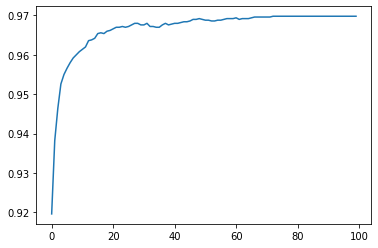

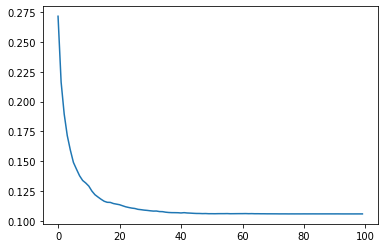

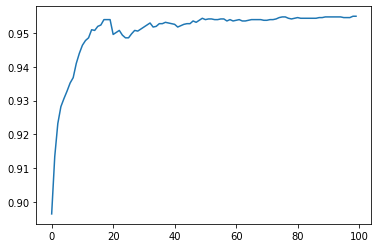

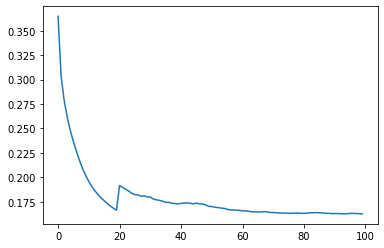

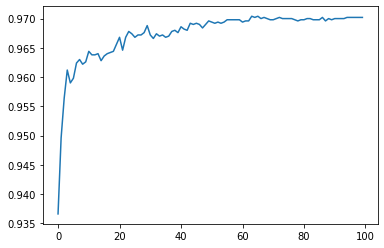

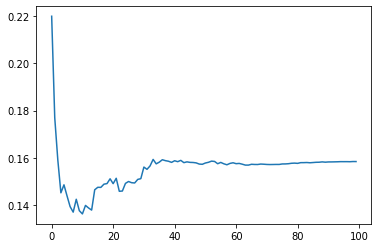

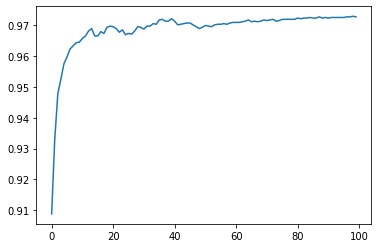

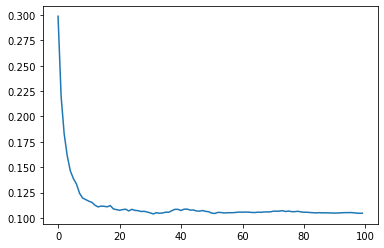

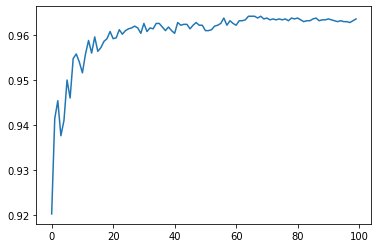

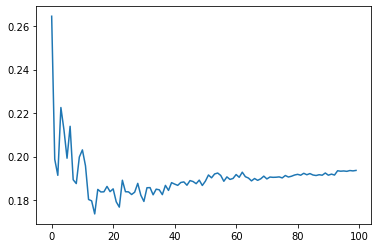

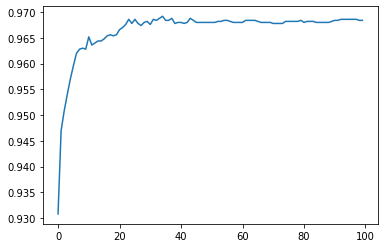

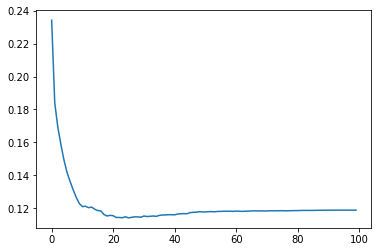

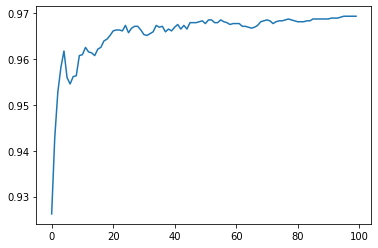

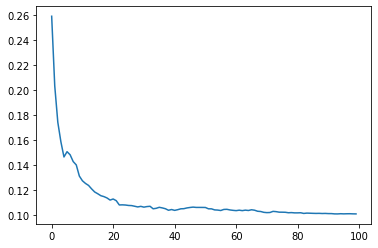

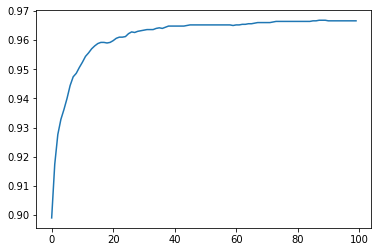

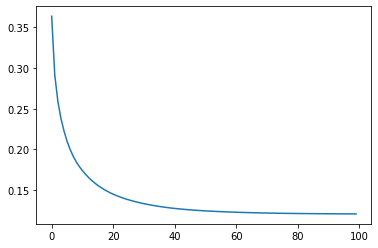

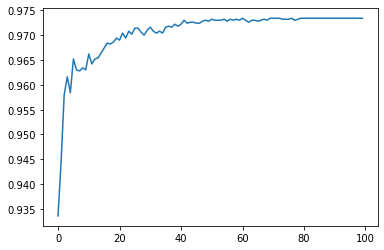

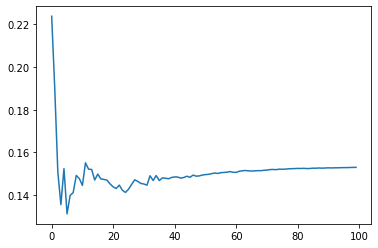

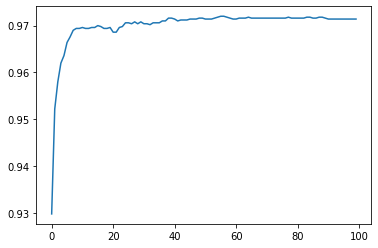

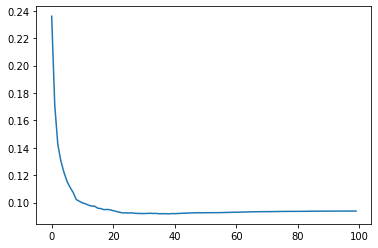

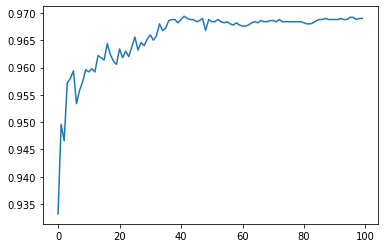

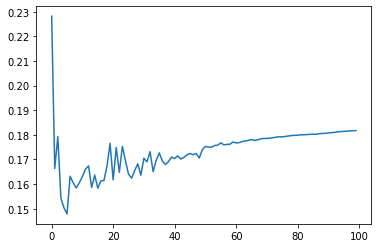

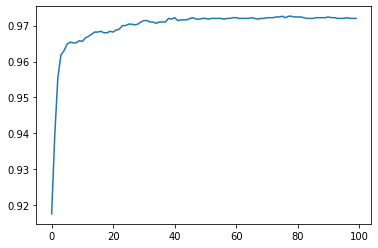

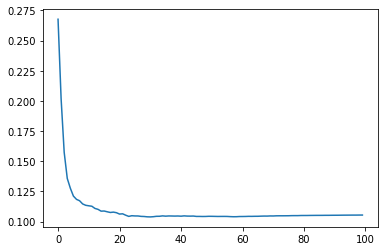

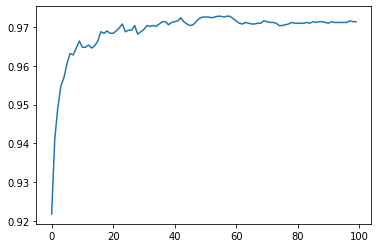

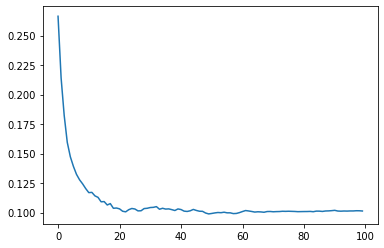

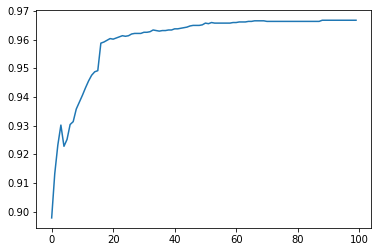

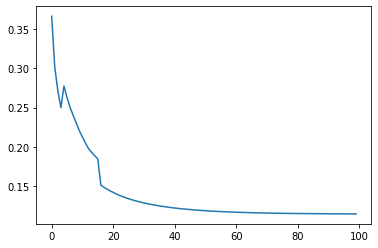

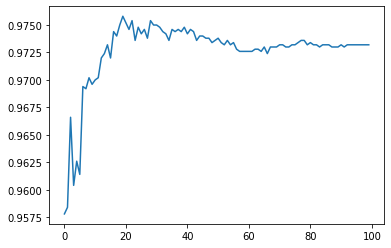

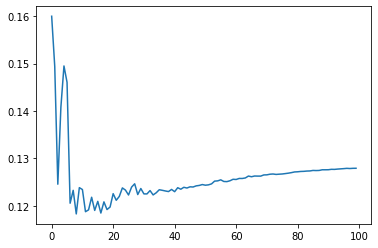

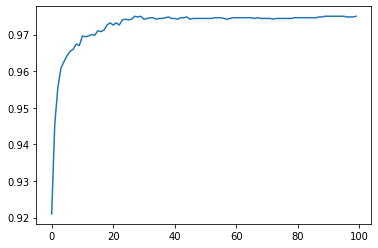

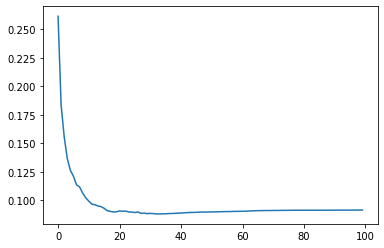

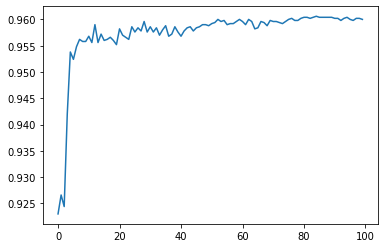

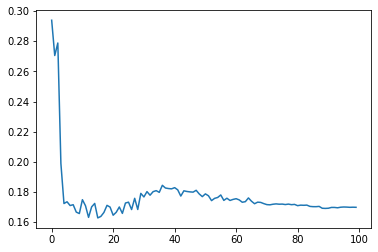

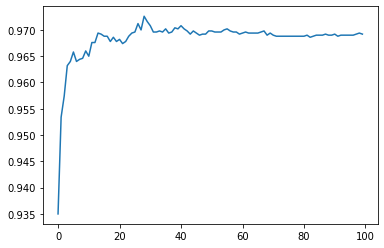

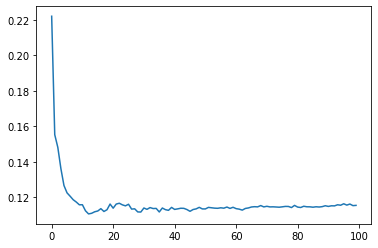

In [29]:
arr = np.array(models)
for i in arr[:,1]:
    t = np.array(i[1])
    plt.plot(t[:,0])
    plt.show()
    plt.plot(t[:,1])
    plt.show()

In [ ]:
from matplotlib import pyplot as plt

npws = np.array(ws[1])

plt.plot(npws[:,0])
plt.show()
plt.plot(npws[:,1])
plt.show()

In [ ]:
results

In [ ]:
# Load data
if "trainX" not in globals():
    trainX, trainY = loadData("train")
    testX, testY = loadData("test")

# Initialize weights randomly
W1 = 2*(np.random.random(size=(NUM_INPUT, NUM_HIDDEN))/NUM_INPUT**0.5) - 1./NUM_INPUT**0.5
b1 = 0.01 * np.ones(NUM_HIDDEN)
W2 = 2*(np.random.random(size=(NUM_HIDDEN, NUM_OUTPUT))/NUM_HIDDEN**0.5) - 1./NUM_HIDDEN**0.5
b2 = 0.01 * np.ones(NUM_OUTPUT)

W1 = W1.T
W2 = W2.T
w = pack(W1, b1, W2, b2)

# Check that the gradient is correct on just a few examples (randomly drawn).
idxs = np.random.permutation(trainX.shape[0])[0:NUM_CHECK]


print(scipy.optimize.check_grad(lambda w_: fCE(np.atleast_2d(trainX[idxs,:]), np.atleast_2d(trainY[idxs,:]), w_), \
                                lambda w_: gradCE(np.atleast_2d(trainX[idxs,:]), np.atleast_2d(trainY[idxs,:]), w_), \
                                w))

# Train the network and obtain the sequence of w's obtained using SGD.
# ws = train(trainX, trainY, testX, testY, w)